{('A', 'B'): Text(-0.5, 0.25, '20'),
 ('A', 'C'): Text(-0.5, 0.75, '5'),
 ('B', 'C'): Text(0.0, 0.5, '3'),
 ('B', 'D'): Text(0.5, 0.25, '1'),
 ('C', 'D'): Text(0.5, 0.75, '1')}

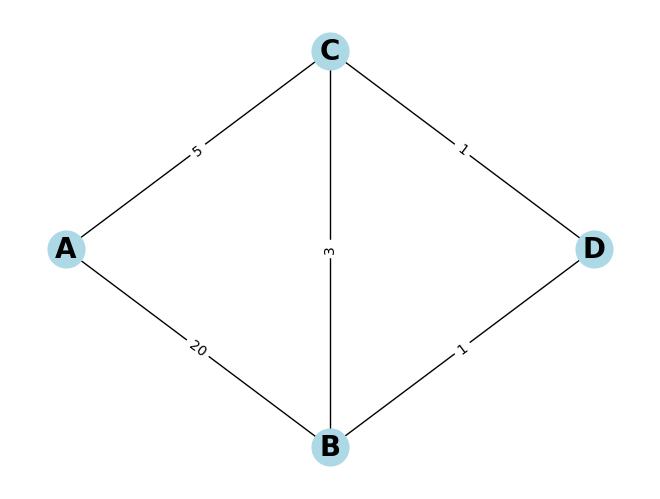

In [834]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

graph = nx.Graph()

graph.add_node("A")
graph.add_node("B")
graph.add_node("C")
graph.add_node("D")

# SCENARIO 1
graph.add_edge("A", "B", weight=20)
graph.add_edge("A", "C", weight=5)
graph.add_edge("B", "C", weight=3)
graph.add_edge("B", "D", weight=1)
graph.add_edge("C", "D", weight=1)

# draw the graph with edge weights show
pos = {
    "A": np.array([-1, 0.5]),
    "B": np.array([0, 0]),
    "C": np.array([0, 1.0]),
    "D": np.array([1, 0.5]),
}
#

# # SCENARIO 2
# graph.add_edge("A", "B", weight=5)
# graph.add_edge("A", "C", weight=5)
# graph.add_edge("B", "C", weight=5)
# graph.add_edge("B", "D", weight=1)
# graph.add_edge("C", "D", weight=1.4)

# # draw the graph with edge weights show
# pos = {
#     "A": np.array([-1, 0.5]),
#     "B": np.array([0, 0]),
#     "C": np.array([0, 1.0]),
#     "D": np.array([1, 0]),
# }
##

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=20,
    font_weight="bold",
)
edge_labels = nx.get_edge_attributes(graph, "weight")


nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)


In [835]:
# for each edge, get the nodes that are lie on 2-hop paths from the source to the target


def edge(a, b):
    return (a, b) if a < b else (b, a)


opposing_nodes_dict = {}

for edg_ in graph.edges():
    start, end = tuple(np.array(edge(*edg_)))

    source_neighbors = list(graph.neighbors(start))
    target_neighbors = list(graph.neighbors(end))
    intersection = list(set(target_neighbors).intersection(set(source_neighbors)))
    opposing_nodes_dict[edg_] = intersection

print(opposing_nodes_dict)

{('A', 'B'): ['C'], ('A', 'C'): ['B'], ('B', 'C'): ['D', 'A'], ('B', 'D'): ['C'], ('C', 'D'): ['B']}


In [836]:
tris = {}


def add_triangle_with_opposing_sidelengths(faces: tuple, edgelengths: tuple):
    SORT = np.argsort(faces)
    faces = tuple(np.array(faces)[SORT])
    edgelengths = tuple(np.array(edgelengths)[SORT])
    tris[faces] = edgelengths


def remove_triangle(faces: tuple):
    faces = tuple(np.sort(faces))
    del tris[faces]


def get_triangle_with_opposite_sidelengths(faces: tuple):
    SORT = np.argsort(faces)
    UNSORT = np.argsort(SORT)
    faces = np.array(faces)[SORT]
    lengths = tris.get(tuple(faces))
    return np.array(lengths)[UNSORT]


def triangle_exists(faces: tuple):
    faces = tuple(np.sort(faces))
    return tris.get(faces) is not None

Triangle exists. Will repair: True
A, B, C
3 5 20
Triangle exists. Will repair: True
B, C, D
1 1 3
FIXING OPPOSING TRIANGLE: B, C, A+B
lengths:
4.0 10.0 3.0
Triangle exists. Will repair: True
A, A+B, C
4.0 5.0 10.0
Triangle exists. Will repair: True
A+B, B, B+C
1.5 7.467 10.0
Triangle exists. Will repair: True
A+B, B+C, C
1.5 4.0 7.467
FIXING OPPOSING TRIANGLE: A+B, B+C, A+B+B
lengths:
4.4835 5.0 7.467
Triangle exists. Will repair: False
B, B+C, D
1.0 1.0 1.5
Triangle exists. Will repair: False
B+C, C, D
1.0 1.0 1.5
Triangle exists. Will repair: False
A, A+A+B, C
4.5 5.0 5.0
Triangle exists. Will repair: False
A+A+B, A+B, C
4.0 4.5 5.0
Triangle exists. Will repair: True
A+B+B, B, B+C
1.5 4.4835 5.0
Triangle exists. Will repair: False
A+B, A+B+B, A+B+B+C
2.935 3.7335 5.0
Triangle exists. Will repair: False
B+C, A+B+B, A+B+B+C
2.935 3.7335 4.4835
Triangle exists. Will repair: False
A+B, C, A+B+B+C
2.75 3.7335 4.0
Triangle exists. Will repair: True
A+B+B+C, B+C, C
1.5 2.75 3.7335
FIXING O

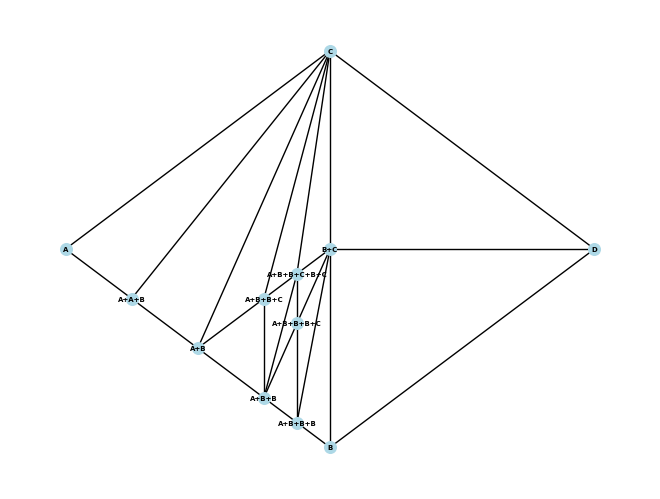

In [837]:
import numpy as np


# get all triangles in the graph


original_faces = [tuple(np.array(["A", "B", "C"])), tuple(np.array(["B", "C", "D"]))]

tris = {}
for face in original_faces:
    lengths = []
    for i, j in [(1, 2), (0, 2), (0, 1)]:
        a, b = edge(face[i], face[j])
        lengths.append(graph.get_edge_data(a, b)["weight"])

    add_triangle_with_opposing_sidelengths(face, tuple(lengths))


def should_subdivide(l1, l2, l3):
    longest = max(l1, l2, l3)
    shortest = min(l1, l2, l3)
    medium = l1 + l2 + l3 - longest - shortest

    is_triangle = longest < (medium + shortest)

    return not is_triangle or (longest * 0.5 >= shortest)


triangles_to_visit = list(tris.keys())

i = 0
while triangles_to_visit:
    if i == 1100:
        break
    faces = triangles_to_visit.pop(0)
    if not triangle_exists(faces):
        continue

    edgelengths = np.array(get_triangle_with_opposite_sidelengths(faces))
    faces = np.array(faces)
    SORT = np.argsort(edgelengths)
    faces = faces[SORT]
    edgelengths = edgelengths[SORT]

    medium_node, short_node, corner_node = faces
    short_side, medium_side, long_side = edgelengths

    will_divide = should_subdivide(short_side, medium_side, long_side)
    print("Triangle exists. Will repair:", will_divide)
    print(", ".join(faces))
    print(short_side, medium_side, long_side)
    if will_divide:
        i += 1
        # insert new point
        new_node = f"{medium_node}+{short_node}"
        graph.add_node(new_node)

        corner_nodes_list = [
            x
            for x in opposing_nodes_dict[edge(medium_node, short_node)]
            if x != corner_node
        ]

        if len(corner_nodes_list) == 1:
            other_corner_node = corner_nodes_list[0]
        else:
            other_corner_node = None

        # FIX THE OPPOSING TRIANGLE (if it exists) 🥵 🤮🤮🤮🤮🤮🤮🤮
        if other_corner_node:
            other_tri = (medium_node, short_node, other_corner_node)
            print("FIXING OPPOSING TRIANGLE:", ", ".join(other_tri))
            o_short_side, o_medium_side, o_long_side = (
                get_triangle_with_opposite_sidelengths(other_tri)
            )

            print("lengths:")
            print(o_short_side, o_medium_side, o_long_side)

            assert o_long_side == long_side, f"{o_long_side} != {long_side}"

            cos_other_medium_angle = (
                o_medium_side**2 + long_side**2 - o_short_side**2
            ) / (2 * o_medium_side * long_side)

            other_new_length = np.sqrt(
                (long_side / 2) ** 2
                + o_medium_side**2
                - 2 * (long_side / 2) * o_medium_side * cos_other_medium_angle
            ).round(3)

            # add edge between newpoint and opposite
            graph.add_edge(*edge(new_node, other_corner_node), weight=other_new_length)
            # print("C, CB", opposing_nodes_dict.get(edge("C", "CB")))
            opposing_nodes_dict[edge(new_node, other_corner_node)] = [
                short_node,
                medium_node,
            ]
            opposing_nodes_dict[edge(medium_node, other_corner_node)].remove(short_node)
            opposing_nodes_dict[edge(medium_node, other_corner_node)].append(new_node)
            opposing_nodes_dict[edge(short_node, other_corner_node)].remove(medium_node)
            opposing_nodes_dict[edge(short_node, other_corner_node)].append(new_node)

            remove_triangle(other_tri)

            add_triangle_with_opposing_sidelengths(
                (medium_node, new_node, other_corner_node),
                (other_new_length, o_medium_side, long_side / 2),
            )

            add_triangle_with_opposing_sidelengths(
                (short_node, new_node, other_corner_node),
                (other_new_length, o_short_side, long_side / 2),
            )

            triangles_to_visit.append(
                tuple(np.sort([medium_node, new_node, other_corner_node]))
            )

            triangles_to_visit.append(
                tuple(np.sort([new_node, short_node, other_corner_node]))
            )

        # FIX THE CURRENT TRIANGLE:

        t = 0.5
        pos[new_node] = pos[medium_node] * (1 - t) + pos[short_node] * (t)

        graph.remove_edge(*edge(medium_node, short_node))
        # add edges between newpoint and long[0] and long[1]
        graph.add_edge(*edge(medium_node, new_node), weight=np.round(long_side * t, 4))
        graph.add_edge(*edge(new_node, short_node), weight=np.round(long_side * t, 4))
        opposing_nodes_dict[edge(new_node, medium_node)] = list.copy(
            opposing_nodes_dict[edge(medium_node, short_node)]
        )
        opposing_nodes_dict[edge(new_node, short_node)] = list.copy(
            opposing_nodes_dict[edge(medium_node, short_node)]
        )

        new_length = np.round(0.5 * (short_side + medium_side), 4)

        graph.add_edge(*edge(new_node, corner_node), weight=new_length)
        opposing_nodes_dict[edge(new_node, corner_node)] = [short_node, medium_node]
        opposing_nodes_dict[edge(medium_node, corner_node)].remove(short_node)
        opposing_nodes_dict[edge(medium_node, corner_node)].append(new_node)
        opposing_nodes_dict[edge(short_node, corner_node)].remove(medium_node)
        opposing_nodes_dict[edge(short_node, corner_node)].append(new_node)
        del opposing_nodes_dict[edge(medium_node, short_node)]

        triangles_to_visit.append(tuple(np.sort([new_node, medium_node, corner_node])))

        triangles_to_visit.append(tuple(np.sort([new_node, short_node, corner_node])))

        add_triangle_with_opposing_sidelengths(
            (medium_node, new_node, corner_node),
            (new_length, medium_side, long_side / 2),
        )

        add_triangle_with_opposing_sidelengths(
            (short_node, new_node, corner_node),
            (new_length, short_side, long_side / 2),
        )

        remove_triangle(faces)

    else:
        s = (long_side + medium_side + short_side) / 2
        area = (s * (s - long_side) * (s - medium_side) * (s - short_side)) ** 0.5

# draw the graph with edge weights shown
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=70,
    node_color="lightblue",
    font_size=5,
    font_weight="bold",
)
edge_labels = nx.get_edge_attributes(graph, "weight")
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels);

In [838]:
tris

{(np.str_('B'), np.str_('B+C'), np.str_('D')): (np.float64(1.0),
  np.float64(1.0),
  np.float64(1.5)),
 (np.str_('B+C'), np.str_('C'), np.str_('D')): (np.float64(1.0),
  np.float64(1.0),
  np.float64(1.5)),
 (np.str_('A'), np.str_('A+A+B'), np.str_('C')): (np.float64(4.5),
  np.float64(5.0),
  np.float64(5.0)),
 (np.str_('A+A+B'), np.str_('A+B'), np.str_('C')): (np.float64(4.0),
  np.float64(4.5),
  np.float64(5.0)),
 (np.str_('A+B'), np.str_('A+B+B'), np.str_('A+B+B+C')): (np.float64(2.935),
  np.float64(3.7335),
  np.float64(5.0)),
 (np.str_('A+B'), np.str_('A+B+B+C'), np.str_('C')): (np.float64(2.75),
  np.float64(4.0),
  np.float64(3.7335)),
 (np.str_('A+B+B+B'), np.str_('B'), np.str_('B+C')): (np.float64(1.5),
  np.float64(2.9918),
  np.float64(2.5)),
 (np.str_('A+B+B'),
  np.str_('A+B+B+C'),
  np.str_('A+B+B+C+B+C')): (np.float64(1.86675), np.float64(3.297), np.float64(2.935)),
 (np.str_('A+B+B+C'),
  np.str_('A+B+B+C+B+C'),
  np.str_('C')): (np.float64(2.125), np.float64(2.75),

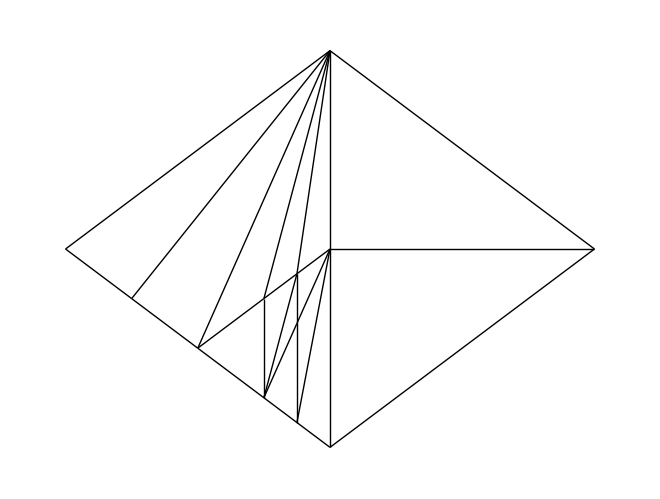

In [839]:
nx.draw(
    graph,
    pos,
    with_labels=False,
    node_size=0,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
)
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels);

In [840]:
def hyperbolic_distance(a, b):
    dist = np.arccosh(
        1
        + 2
        * np.sum((a - b) ** 2, axis=1)
        / ((1 - np.sum(a**2, axis=1)) * (1 - np.sum(b**2, axis=1)))
    )
    return dist


def different_distance(a, b):
    dist = (
        np.exp(
            0.5
            * np.arccosh(
                1
                + 2
                * np.sum((a - b) ** 2, axis=1)
                / ((1 - np.sum(a**2, axis=1)) * (1 - np.sum(b**2, axis=1)))
            )
        )
        - 1
    ) * np.exp(np.linalg.norm(a - b, axis=1))
    return dist.round(3)


creating mesh


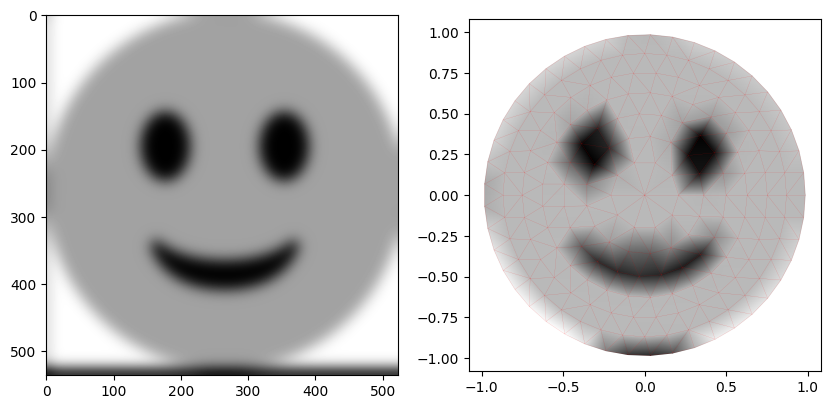

In [843]:
# load smiley.png with numpy
image = plt.imread("../../smiley2.png")
# make grayscale
image = image.mean(axis=2)
# blur image
import scipy.ndimage

image = scipy.ndimage.gaussian_filter(image, 10)
width = image.shape[1]
height = image.shape[0]

import DECMesh as dm

mesh = dm.Mesh.from_obj("../../meshes/small-disc.obj")

import matplotlib.tri as mtri

triang = mtri.Triangulation(mesh.vertices[:, 0], mesh.vertices[:, 2], mesh.faces)

# get all barycenters:
barycenters = np.mean(mesh.vertices[:, [0, 2]][triang.triangles], axis=1)
barycenters = mesh.vertices[:, [0, 2]]

# get interpolated color at each vertex
colors = scipy.ndimage.map_coordinates(
    image,
    [
        height - height * (barycenters[:, 1] / 2 + 0.5),
        width * (barycenters[:, 0] / 2 + 0.5),
    ],
    order=1,
    mode="nearest",
)

edge_values = mesh.d0 @ colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[1].tripcolor(triang, colors, cmap="gray", shading="gouraud")
# plot mesh
ax[1].triplot(triang, "r-", lw=0.1, alpha=0.5)

ax[0].imshow(image, cmap="gray")
plt.show()

creating mesh
added 353 nodes
total nodes: 552


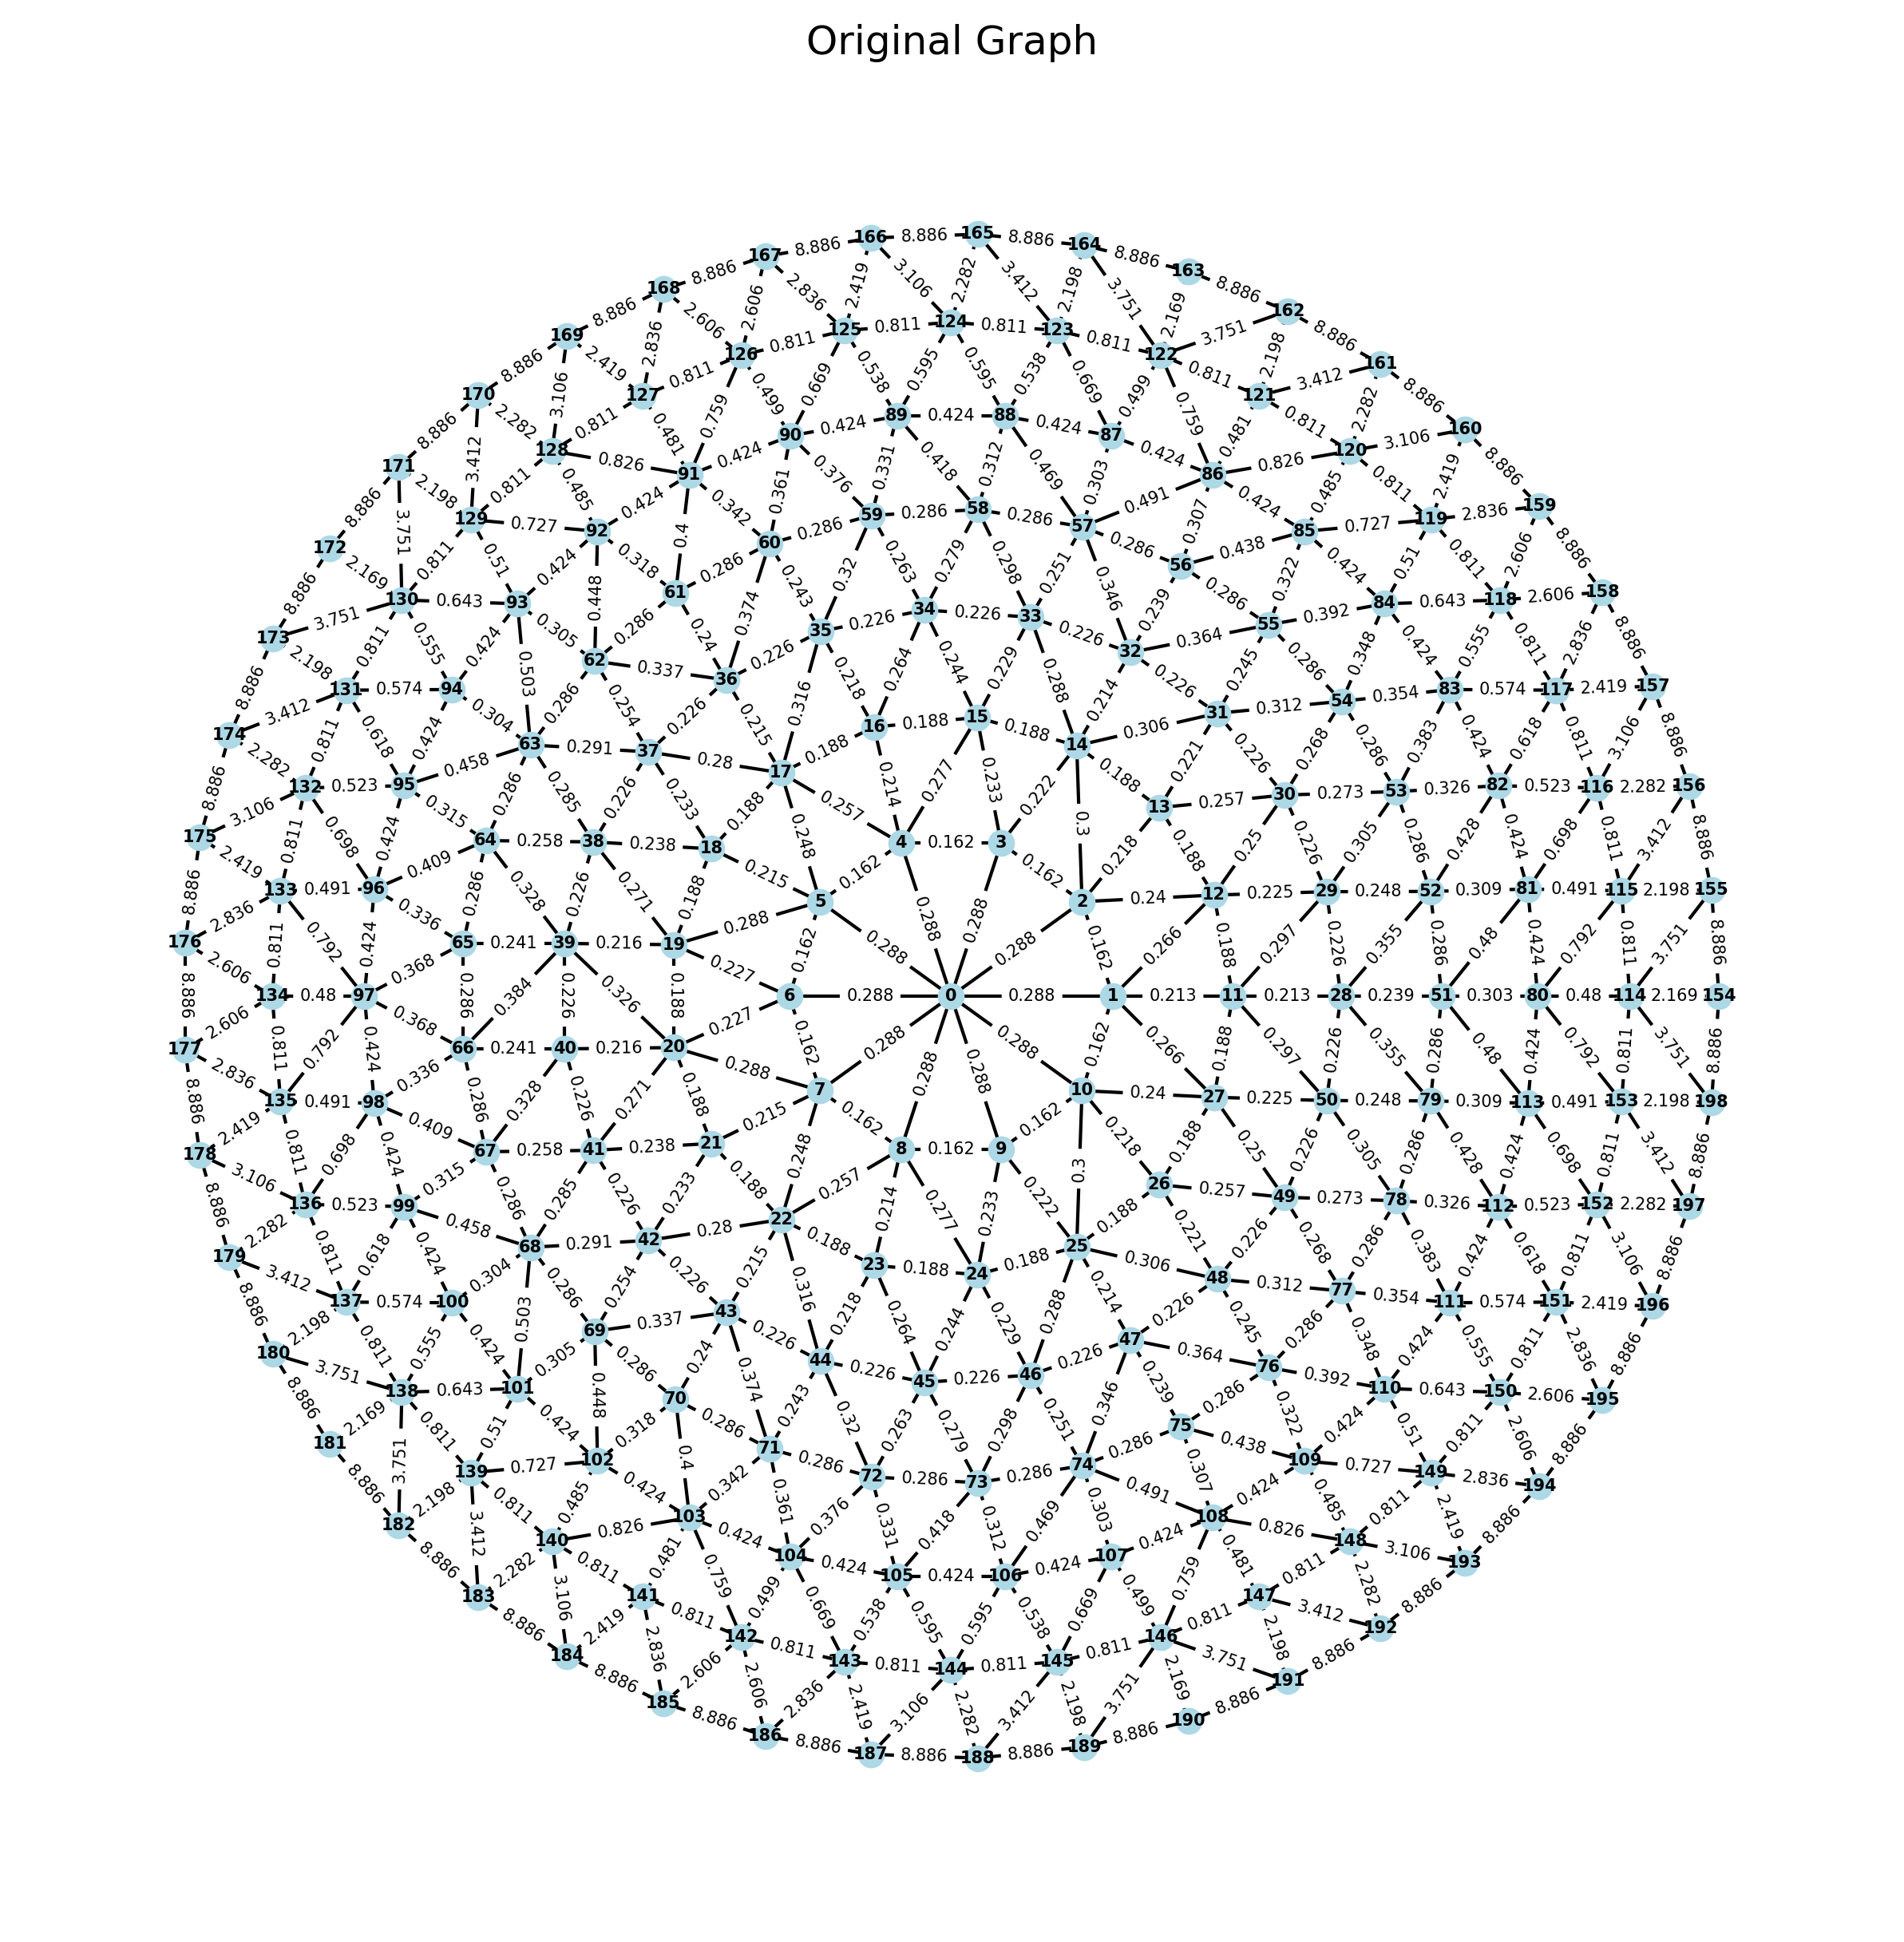

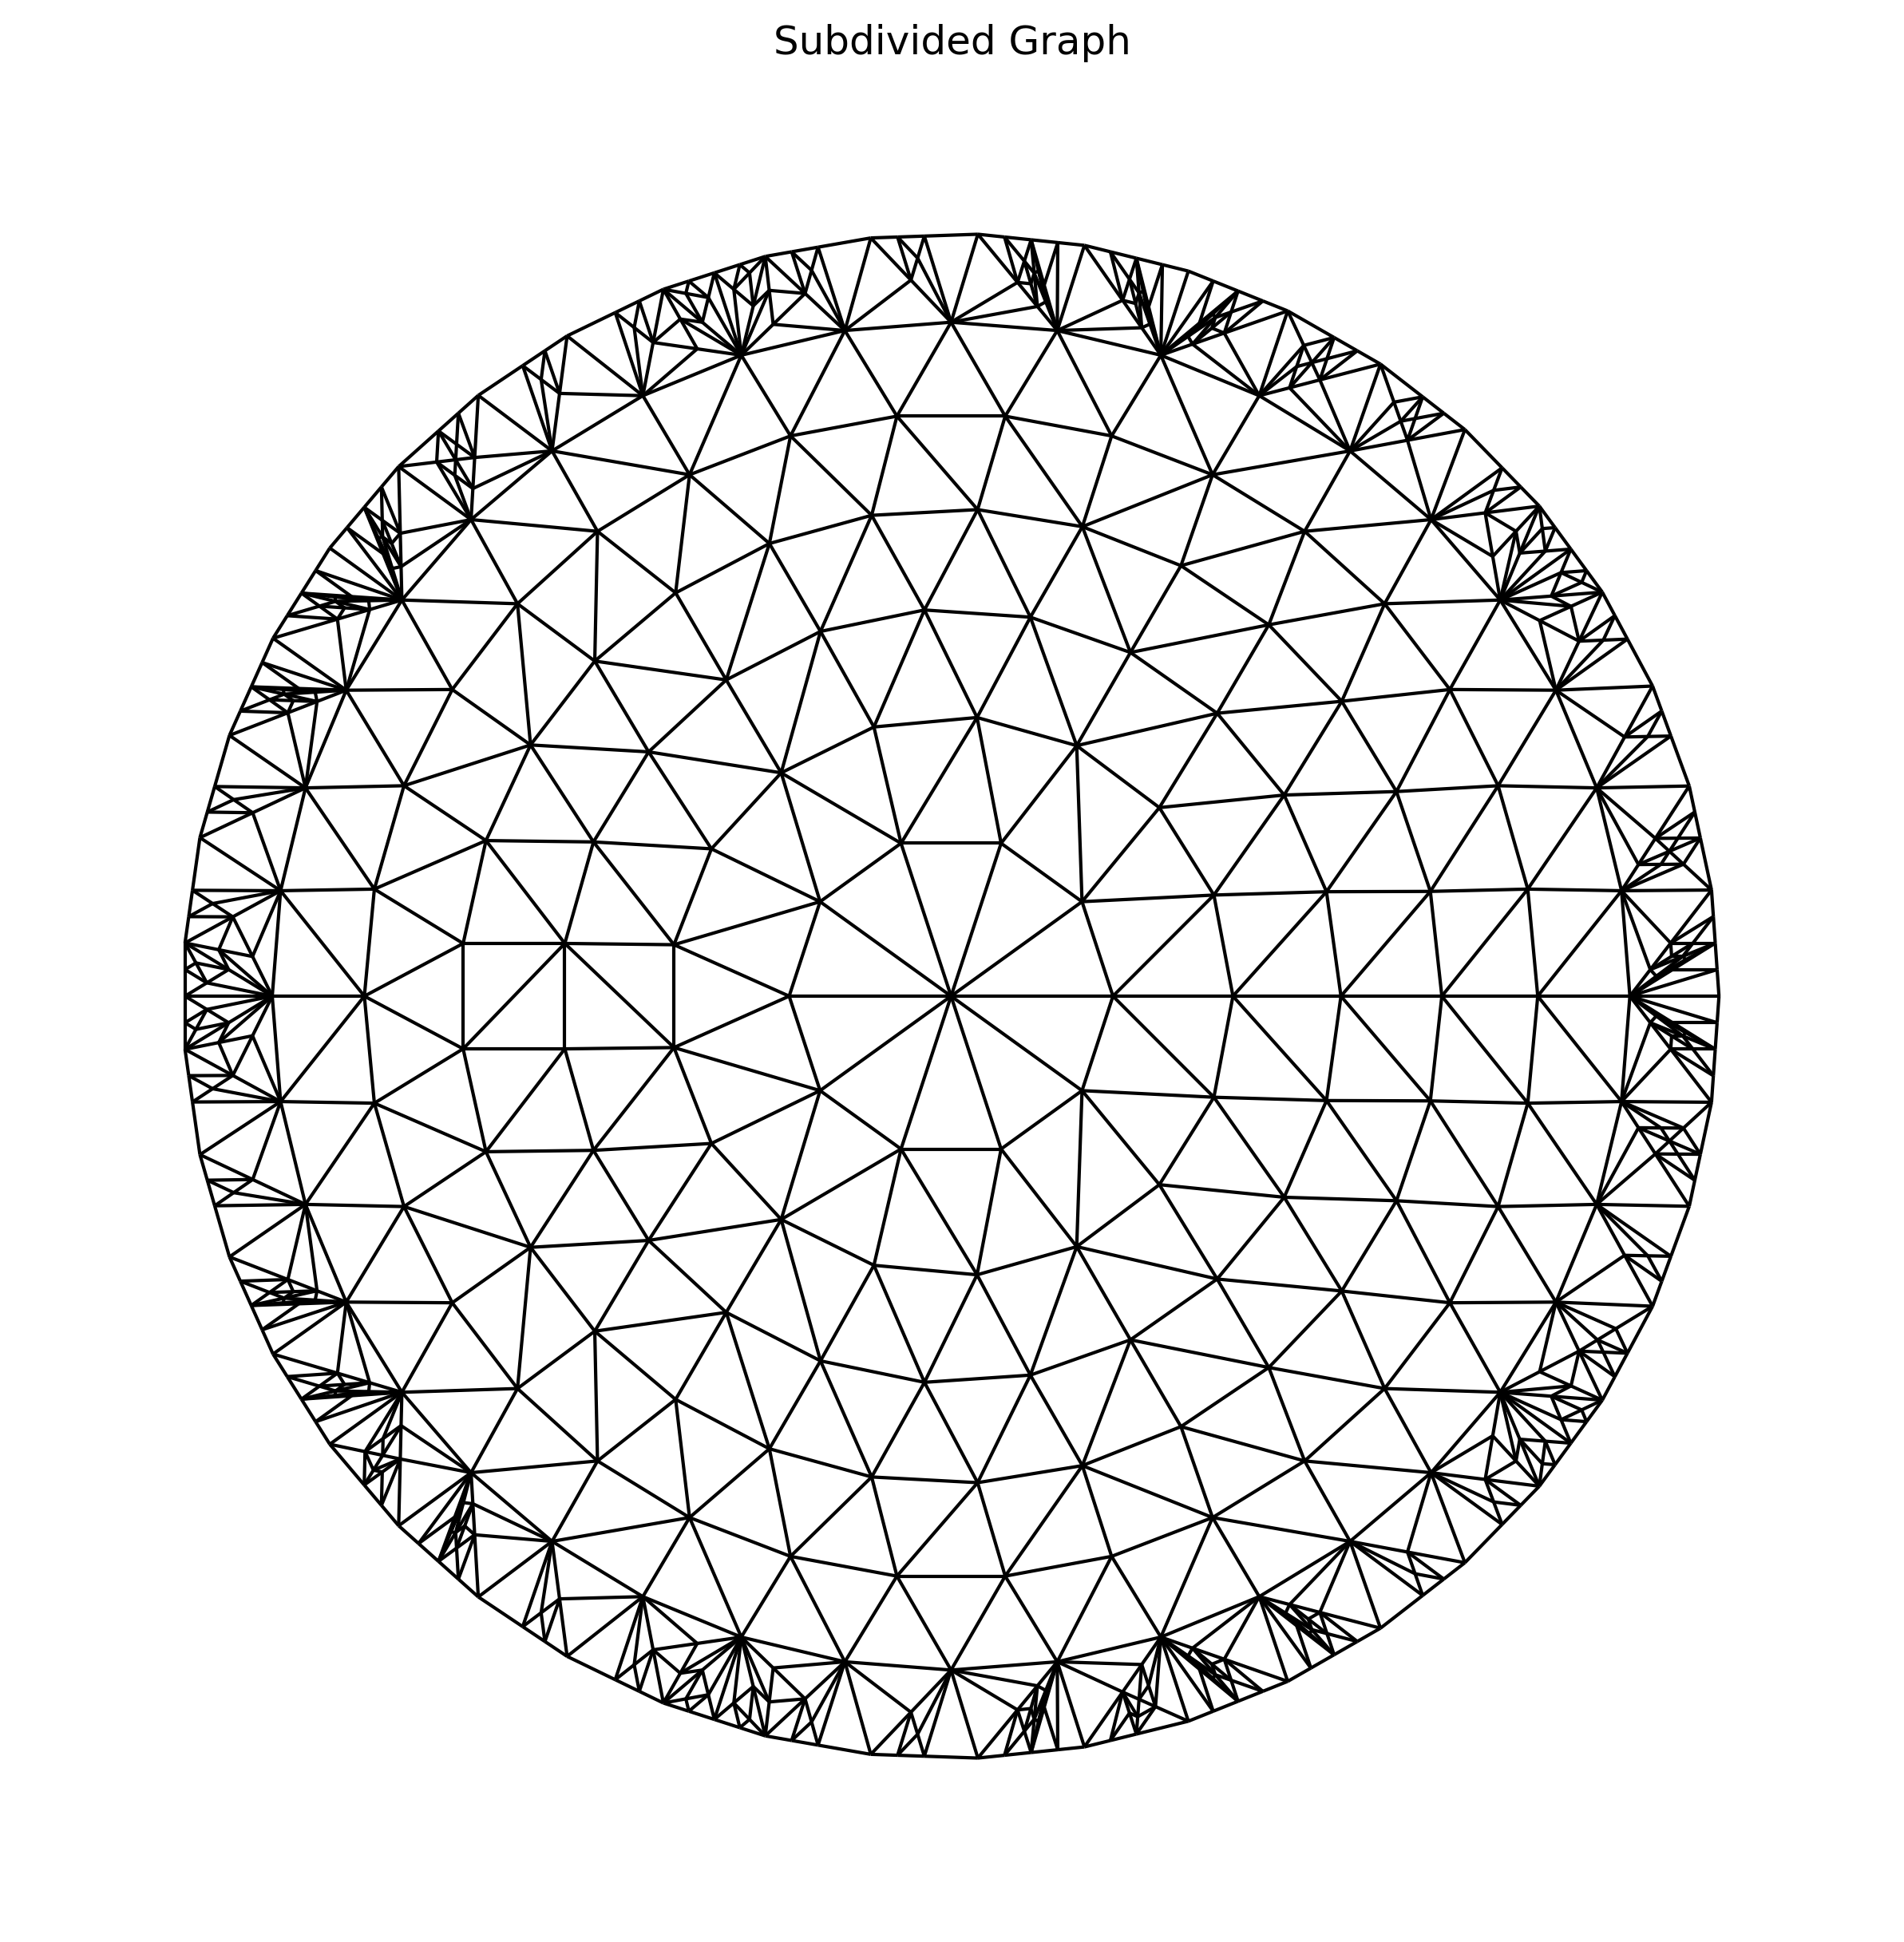

In [841]:
from typing import Any
import numpy as np
import DECMesh as dm

mesh = dm.Mesh.from_obj("../../meshes/small-disc.obj", lazy=False)


def triangulate_mesh_with_edge_distances(mesh: dm.Mesh, distance_map):
    opposing_nodes_dict = {}
    for edge_, opposing in zip(mesh.edges, mesh.opposing_vertices):
        a, b = edge(*edge_)
        opposing_nodes_dict[(a, b)] = opposing

    faces = mesh.faces
    vertices = mesh.vertices[:, [0, 2]]
    pos = {i: vertices[i] for i in range(len(vertices))}

    graph = nx.Graph()
    for v in range(len(vertices)):
        graph.add_node(v)

    for f in faces:
        for i, j in [(1, 2), (0, 2), (0, 1)]:
            a, b = edge(f[i], f[j])
            pos_a, pos_b = pos[a], pos[b]
            pos_a = np.array([pos_a]).reshape(1, 2)
            pos_b = np.array([pos_b]).reshape(1, 2)
            graph.add_edge(a, b, weight=different_distance(pos_a, pos_b)[0])

    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    # draw the graph with edge weights shown
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=50,
        node_color="lightblue",
        font_size=5,
        font_weight="bold",
        ax=ax,
    )
    edge_labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels=edge_labels, font_size=5, ax=ax
    )
    ax.title.set_text("Original Graph")

    original_faces = faces

    tris = {}
    for face in original_faces:
        lengths = []
        for i, j in [(1, 2), (0, 2), (0, 1)]:
            a, b = edge(face[i], face[j])
            pos_a, pos_b = pos[a], pos[b]
            pos_a = np.array([pos_a]).reshape(1, 2)
            pos_b = np.array([pos_b]).reshape(1, 2)
            lengths.append(different_distance(pos_a, pos_b)[0])

        add_triangle_with_opposing_sidelengths(face, tuple(lengths))

    def should_subdivide(l1, l2, l3):
        longest = max(l1, l2, l3)
        shortest = min(l1, l2, l3)
        medium = l1 + l2 + l3 - longest - shortest

        is_triangle = longest < (medium + shortest)

        return not is_triangle or (longest * 0.5 >= shortest)

    triangles_to_visit = list(tris.keys())

    i = 0
    while triangles_to_visit:
        faces = triangles_to_visit.pop(0)
        # print("faces:", faces)
        if not triangle_exists(faces):
            continue

        edgelengths = np.array(get_triangle_with_opposite_sidelengths(faces))
        faces = np.array(faces)
        SORT = np.argsort(edgelengths)
        faces = faces[SORT]
        edgelengths = edgelengths[SORT]

        medium_node, short_node, corner_node = faces
        short_side, medium_side, long_side = edgelengths

        # print("node:")
        # print(medium_node, short_node, corner_node)
        # print(short_side, medium_side, long_side)

        will_divide = should_subdivide(short_side, medium_side, long_side)
        # print("Triangle exists. Will repair:", will_divide)
        # print(", ".join(faces))
        # print(short_side, medium_side, long_side)
        if will_divide:
            i += 1
            # insert new point
            new_node = len(pos) + 1
            graph.add_node(new_node)

            corner_nodes_list = [
                x
                for x in opposing_nodes_dict[edge(medium_node, short_node)]
                if x != corner_node
            ]

            if len(corner_nodes_list) == 1:
                other_corner_node = corner_nodes_list[0]
            else:
                other_corner_node = None

            # FIX THE OPPOSING TRIANGLE (if it exists) 🥵 🤮🤮🤮🤮🤮🤮🤮
            if other_corner_node:
                other_tri = (medium_node, short_node, other_corner_node)
                # print("FIXING OPPOSING TRIANGLE:", ", ".join(other_tri))
                o_short_side, o_medium_side, o_long_side = (
                    get_triangle_with_opposite_sidelengths(other_tri)
                )

                # print("lengths:")
                # print(o_short_side, o_medium_side, o_long_side)

                assert o_long_side == long_side, f"{o_long_side} != {long_side}"

                cos_other_medium_angle = (
                    o_medium_side**2 + long_side**2 - o_short_side**2
                ) / (2 * o_medium_side * long_side)

                other_new_length = np.sqrt(
                    (long_side / 2) ** 2
                    + o_medium_side**2
                    - 2 * (long_side / 2) * o_medium_side * cos_other_medium_angle
                ).round(3)

                # add edge between newpoint and opposite
                graph.add_edge(
                    *edge(new_node, other_corner_node), weight=other_new_length
                )
                # print("C, CB", opposing_nodes_dict.get(edge("C", "CB")))
                opposing_nodes_dict[edge(new_node, other_corner_node)] = [
                    short_node,
                    medium_node,
                ]
                opposing_nodes_dict[edge(medium_node, other_corner_node)].remove(
                    short_node
                )
                opposing_nodes_dict[edge(medium_node, other_corner_node)].append(
                    new_node
                )
                opposing_nodes_dict[edge(short_node, other_corner_node)].remove(
                    medium_node
                )
                opposing_nodes_dict[edge(short_node, other_corner_node)].append(
                    new_node
                )

                remove_triangle(other_tri)

                add_triangle_with_opposing_sidelengths(
                    (medium_node, new_node, other_corner_node),
                    (other_new_length, o_medium_side, long_side / 2),
                )

                add_triangle_with_opposing_sidelengths(
                    (short_node, new_node, other_corner_node),
                    (other_new_length, o_short_side, long_side / 2),
                )

                triangles_to_visit.append(
                    tuple(np.sort([medium_node, new_node, other_corner_node]))
                )

                triangles_to_visit.append(
                    tuple(np.sort([new_node, short_node, other_corner_node]))
                )

            # FIX THE CURRENT TRIANGLE:

            t = 0.5
            pos[new_node] = pos[medium_node] * (1 - t) + pos[short_node] * (t)

            graph.remove_edge(*edge(medium_node, short_node))
            # add edges between newpoint and long[0] and long[1]
            graph.add_edge(
                *edge(medium_node, new_node), weight=np.round(long_side * t, 4)
            )
            graph.add_edge(
                *edge(new_node, short_node), weight=np.round(long_side * t, 4)
            )
            opposing_nodes_dict[edge(new_node, medium_node)] = list.copy(
                opposing_nodes_dict[edge(medium_node, short_node)]
            )
            opposing_nodes_dict[edge(new_node, short_node)] = list.copy(
                opposing_nodes_dict[edge(medium_node, short_node)]
            )

            new_length = np.round(0.5 * (short_side + medium_side), 4)

            graph.add_edge(*edge(new_node, corner_node), weight=new_length)
            opposing_nodes_dict[edge(new_node, corner_node)] = [short_node, medium_node]
            opposing_nodes_dict[edge(medium_node, corner_node)].remove(short_node)
            opposing_nodes_dict[edge(medium_node, corner_node)].append(new_node)
            opposing_nodes_dict[edge(short_node, corner_node)].remove(medium_node)
            opposing_nodes_dict[edge(short_node, corner_node)].append(new_node)
            del opposing_nodes_dict[edge(medium_node, short_node)]

            triangles_to_visit.append(
                tuple(np.sort([new_node, medium_node, corner_node]))
            )

            triangles_to_visit.append(
                tuple(np.sort([new_node, short_node, corner_node]))
            )

            add_triangle_with_opposing_sidelengths(
                (medium_node, new_node, corner_node),
                (new_length, medium_side, long_side / 2),
            )

            add_triangle_with_opposing_sidelengths(
                (short_node, new_node, corner_node),
                (new_length, short_side, long_side / 2),
            )

            remove_triangle(faces)

        else:
            s = (long_side + medium_side + short_side) / 2
            area = (s * (s - long_side) * (s - medium_side) * (s - short_side)) ** 0.5


fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
# draw the graph with edge weights shown
nx.draw(
    graph,
    pos,
    with_labels=False,
    node_size=0,
    node_color="lightblue",
    font_size=5,
    font_weight="bold",
    ax=ax,
)
ax.title.set_text("Subdivided Graph")
print("added", i, "nodes")
print("total nodes:", len(graph.nodes))
edge_labels = nx.get_edge_attributes(graph, "weight")
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=5, ax=ax)

# a, b, c = get_triangle_with_opposite_sidelengths((39, 63, 62))
# should_subdivide(a, b, c)
# print(triangles_to_visit)
None

creating mesh


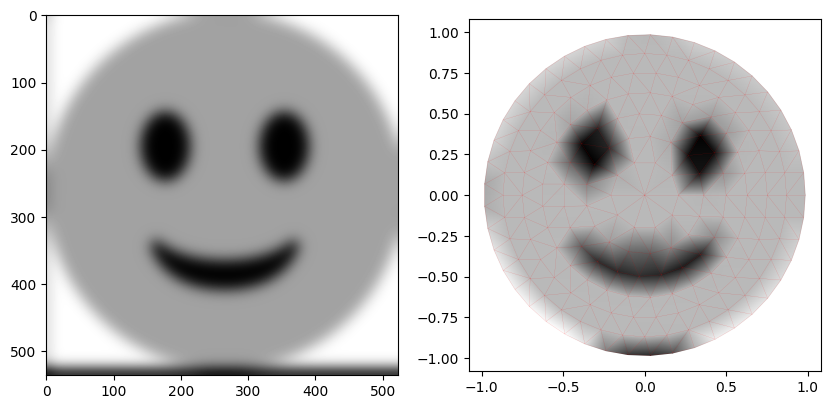